In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import os
import shutil
import re
import pickle as pkl

In [2]:
nonquasi_list = ['Pseudo','Neutral','Adaptive','Neutral_dom','Adaptive_dom','quasi_stablespace20']
quasi_list = [
    'quasi_dom',
    'quasi_env2','quasi_env5','quasi_env10','quasi_env20',
    'quasi_int2','quasi_int25','quasi_int100','quasi_int200',
    'quasi_pop500','quasi_pop1000','quasi_pop5000','quasi_pop10000','quasi_pop50000',
    'quasi_neufrac0.05','quasi_neufrac0.15','quasi_neufrac0.2','quasi_neufrac0.25',
    'quasi_lambda2','quasi_lambda4','quasi_lambda6','quasi_lambda8','quasi_lambda10',
    'quasi_AP0.15','quasi_AP0.35','quasi_AP0.45','quasi_AP0.5'
]
# 

In [3]:
def get_spectrum(mut_df,Ne):
    mut_df['AF'] = mut_df['AF']/(2*Ne)
    Total_alleles = len(mut_df)
    spectrum = []
    for start in np.linspace(0,0.019,20):
        F_alleles = (mut_df['AF'] < start+0.001).sum()/Total_alleles #accumulative
        spectrum.append(F_alleles)
    for start in np.linspace(0.02,0.99,98):
        F_alleles = (mut_df['AF'] < start+0.01).sum()/Total_alleles #accumulative
        spectrum.append(F_alleles)
    return spectrum

In [4]:
def get_mean_spectrum(rep,version):
    target_dir = f'./SLiM/Simulation_log/rep{rep}/{version}_20samples/'
    if version == 'quasi_pop50000':
        N_gen_total = 160000
    else:
        N_gen_total = 200000
    if 'pop' in version:
        Ne = int(re.search(r'pop(\d+)',version)[1])
    else:
        Ne = 10000
    spectrum_list = []
    for N_gen in range(N_gen_total-19000,N_gen_total+1,1000):
        mut_df = pd.read_table(target_dir+f'{version}_{N_gen}.txt',header=None,delim_whitespace=True)
        mut_df = mut_df.rename(columns={4:'ID',7:'s',10:'SG',11:'AF'})
        
        if version == 'quasi_stablespace20':
            mut_dict = {}
            for i,row in mut_df.iterrows():
                if row['ID'] in mut_dict:
                    mut_dict[row['ID']] += row['AF']
                else:
                    mut_dict[row['ID']] = row['AF']
            mut_df = pd.DataFrame(list(mut_dict.items()),columns=['ID', 'AF'])
        
        spectrum = get_spectrum(mut_df,Ne)
        spectrum_list.append(spectrum)
    spectrum_mean = np.mean(spectrum_list,axis=0)    
    return spectrum_mean

In [8]:
#spectrum_final_dict = {}
# for version in nonquasi_list+quasi_list:
# for version in ['quasi_stablespace20']:
#additional_list = ['quasi_env2','quasi_env5','quasi_env10','quasi_env20']
#additional_list = ['quasi_stablespace20']
#additional_list = ['quasi_AP0.1','quasi_AP0.25','quasi_AP0.5','quasi_AP0.75','quasi_AP1']
#nonquasi_list+quasi_list: #nonquasi_list
for version in ['quasi_AP0.15','quasi_AP0.35','quasi_AP0.45','quasi_AP0.5']:
    print(version)
    spectrum_mean_list = []
    for rep in range(1,31):
        print(rep,end='\r',flush=True)
        spectrum_mean = get_mean_spectrum(rep,version)
        spectrum_mean_list.append(spectrum_mean)
    spectrum_final_dict[version] = np.mean(spectrum_mean_list,axis=0)

quasi_AP0.15
quasi_AP0.35
quasi_AP0.45
quasi_AP0.5


In [10]:
# with open('Allele_spectrum_v3.pkl','wb') as file:
#     pkl.dump(spectrum_final_dict,file)

In [5]:
with open('Allele_spectrum_v3.pkl','rb') as file:
    spectrum_final_dict = pkl.load(file)

In [199]:
# for rep in range(1,4):
#     for version in ['NeuDel','NeuDelBen']:
#         mut_df = pd.read_csv(
#             f'./SLiM/Simulation_log/replication/rep{rep}/Mutation_summary_{version}.txt',header=None)
#         mut_df[1] = mut_df[2]
#         mut_df.to_csv(f'./SLiM/Simulation_log/replication/rep{rep}/Mutation_summary_{version}.txt',header=False,index=False)
#         #mut_df.to_csv(f'./Mutation_summary_{version}.txt',header=False,index=False)

In [18]:
mut_df

,ID,mean_selcoef,cur_selcoef,effective_selcoef,AF,isFixed,Gen_S,Gen_E
0,63998503,0.0,0.0,0.0,0.00010,F,199999,-1
1,55127976,0.0,0.0,0.0,0.80200,F,172270,-1
2,63993010,0.0,0.0,0.0,0.00030,F,199982,-1
3,62949620,0.0,0.0,0.0,0.19290,F,196726,-1
4,63998813,0.0,0.0,0.0,0.00005,F,200000,-1
...,...,...,...,...,...,...,...,...
9500,46412644,0.0,0.0,0.0,1.00000,T,145025,199550
9501,53802933,0.0,0.0,0.0,1.00000,T,168134,199601
9502,54294769,0.0,0.0,0.0,1.00000,T,169671,199632
9503,52559387,0.0,0.0,0.0,1.00000,T,164244,199838


In [11]:
summary_dict = {}
selcoeff_cutoff = 0 # 1/(2*Ne)

for version in nonquasi_list+quasi_list:
    print(version)
    if version == 'Pseudo':
        summary_dict['Type'] = [version]
    else:
        summary_dict['Type'].append(version)

    if 'pop' in  version:
        Ne = int(version.split('pop')[1])
    else:
        Ne = 10000
        
    #selcoeff_cutoff = 1/(2*Ne) # 1/(2*Ne)
    
    for rep in range(1,31):
        print(rep,end='\r',flush=True)
        mut_df = pd.read_csv(
            f'./SLiM/Simulation_log/rep{rep}/Mutation_summary_{version}.txt')
        #sim_df = pd.read_csv(f'Simulation_log/sim_summary{version}.txt')
        #mut_df = mut_df.rename(
        #    columns={0:'ID',1:'mean_selcoef',2:'cur_selcoef',3:'AF',4:'isFixed',5:'Gen_S',6:'Gen_E'})

        if Ne == 50000:
            mut_df_sub = mut_df[(mut_df['Gen_E']>=40000) | (mut_df['Gen_E']==-1)] #############
        else:
            mut_df_sub = mut_df[(mut_df['Gen_E']>=80000) | (mut_df['Gen_E']==-1)] #############

        for mut_type in ['P','S']: # P for polymorphism, S for substitution
            if mut_type == 'P':
                idx = mut_df_sub['isFixed'] == 'F'
            elif mut_type == 'S':
                idx = mut_df_sub['isFixed'] == 'T'
            for fitness_type in ['effective','inst']:
                if fitness_type == 'effective':
                    if version in nonquasi_list:
                        key = 'cur_selcoef'
                    else:
                        key = 'effective_selcoef_1'
                elif fitness_type == 'inst':
                    key = 'cur_selcoef'
                if version == 'Pseudo':
                    summary_dict[f'deleterious_{fitness_type}_{mut_type}_{rep}'] = \
                        [(mut_df_sub.loc[idx,key] < -selcoeff_cutoff).sum()]
                    summary_dict[f'beneficial_{fitness_type}_{mut_type}_{rep}'] = \
                        [(mut_df_sub.loc[idx,key] > selcoeff_cutoff).sum()]
                    summary_dict[f'neutral_{fitness_type}_{mut_type}_{rep}'] = \
                        [((mut_df_sub.loc[idx,key]).abs() <= selcoeff_cutoff).sum()]
                else:
                    summary_dict[f'deleterious_{fitness_type}_{mut_type}_{rep}'].append(
                        (mut_df_sub.loc[idx,key] < -selcoeff_cutoff).sum())
                    summary_dict[f'beneficial_{fitness_type}_{mut_type}_{rep}'].append(
                        (mut_df_sub.loc[idx,key] > selcoeff_cutoff).sum())
                    summary_dict[f'neutral_{fitness_type}_{mut_type}_{rep}'].append(
                        ((mut_df_sub.loc[idx,key]).abs() <= selcoeff_cutoff).sum())
        if version == 'Pseudo':
            #summary_dict[f'dNdneutral_{rep}'] = [(mut_df_sub['isFixed'] == 'T').sum()/2560]
            summary_dict[f'dNdneutral_{rep}'] = [(mut_df_sub['isFixed'] == 'T').sum()/1920]
        else:
            #summary_dict[f'dNdneutral_{rep}'].append((mut_df_sub['isFixed'] == 'T').sum()/2560)
            summary_dict[f'dNdneutral_{rep}'].append((mut_df_sub['isFixed'] == 'T').sum()/1920)


    #     print('In the end of simulation:')
    #     for mut_type in ['polymorphism','substitution']:
    #         print(f'Among {mut_type}:')
    #         for fitness_type in ['mean','current']:
    #             print(
    #                 f"{fitness_type} fitness: {summary_dict[mut_type][fitness_type]['beneficial']} beneficial,"
    #                 f"{summary_dict[mut_type][fitness_type]['neutral']} neutral,"
    #                 f"and {summary_dict[mut_type][fitness_type]['deleterious']} deleterious"
    #             )
    #     print(f"dN/d_neutral = { (mut_df_sub['isFixed'] == 'T').sum()/2560 }")

Pseudo
Neutral
Adaptive
Neutral_dom
Adaptive_dom
quasi_stablespace20
quasi_dom
quasi_env2
quasi_env5
quasi_env10
quasi_env20
quasi_int2
quasi_int25
quasi_int100
quasi_int200
quasi_pop500
quasi_pop1000
quasi_pop5000
quasi_pop10000
quasi_pop50000
quasi_neufrac0.05
quasi_neufrac0.15
quasi_neufrac0.2
quasi_neufrac0.25
quasi_lambda2
quasi_lambda4
quasi_lambda6
quasi_lambda8
quasi_lambda10
quasi_AP0.15
quasi_AP0.35
quasi_AP0.45
quasi_AP0.5


In [13]:
#summary_df = pd.DataFrame(summary_dict)
#summary_df.to_csv('SLiM/SLiM_summary_es1_c0.csv',index=False,na_rep='NA')

In [6]:
summary_df = pd.read_csv('SLiM/SLiM_summary_es1_c0.csv')

In [7]:
#meanORinst = 'inst' # 'mean'
for meanORinst in ['inst','effective']:
    for rep in range(1,31):
        for Type in ['P','S']:
            for mut_type in ['beneficial','neutral','deleterious']:
                summary_df[f'{mut_type}_{meanORinst}_{Type}'] = \
                    summary_df.loc[:,[f'{mut_type}_{meanORinst}_{Type}_{rep}' for rep in range(1,31)]].mean(axis=1)


In [8]:
tmp_df = pd.DataFrame()
tmp_df['Type'] = summary_df['Type']
for meanORinst in ['inst','effective']:
    for rep in range(1,31):
        for Type in ['P','S']:
            for mut_type in ['beneficial','neutral','deleterious']:
                tmp_df[f'{mut_type}_{meanORinst}_{Type}_{rep}'] = \
                summary_df[f'{mut_type}_{meanORinst}_{Type}_{rep}']/ \
                (summary_df[f'deleterious_{meanORinst}_{Type}_{rep}'] + summary_df[f'beneficial_{meanORinst}_{Type}_{rep}'] + \
                    summary_df[f'neutral_{meanORinst}_{Type}_{rep}'])
    

/tmp/ipykernel_85728/602306526.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp_df[f'{mut_type}_{meanORinst}_{Type}_{rep}'] = \


In [9]:
plt_df = pd.DataFrame()
plt_df['Type'] = summary_df['Type']
for meanORinst in ['inst','effective']:
    for Type in ['P','S']:
        for mut_type in ['beneficial','neutral','deleterious']:
            plt_df[f'{mut_type}_{meanORinst}_{Type}'] = \
                tmp_df.loc[:,[f'{mut_type}_{meanORinst}_{Type}_{rep}' for rep in range(1,31)]].mean(axis=1)


In [10]:
plt_df = pd.concat([plt_df,summary_df.loc[:,[f'dNdneutral_{rep}' for rep in range(1,31)]]],axis=1)

In [18]:
#plt_df.to_csv('Simulation_summary.csv',index=False)

In [12]:
rcParams_dict = {
    'xtick.bottom': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.spines.right': False,
    'patch.edgecolor':'k',
    'patch.force_edgecolor': True,
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
    'mathtext.fontset':'custom',
    'mathtext.default': 'regular',
    'mathtext.it': 'Arial:italic',
    'mathtext.it': 'Arial:italic',
}
mpl.rcParams.update(rcParams_dict)

color_list = ['C0','C1','C2','C3','C4','C5','C6','tan','C8','C9','yellow','lime']
color_list2 = ['dimgrey','white','lightgrey']
mut_type_list = ['Beneficial','Neutral','Deleterious']
flierprops = dict(marker='.', markerfacecolor='black', markersize=2,
                  linestyle='none')

/tmp/ipykernel_85728/1482341148.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


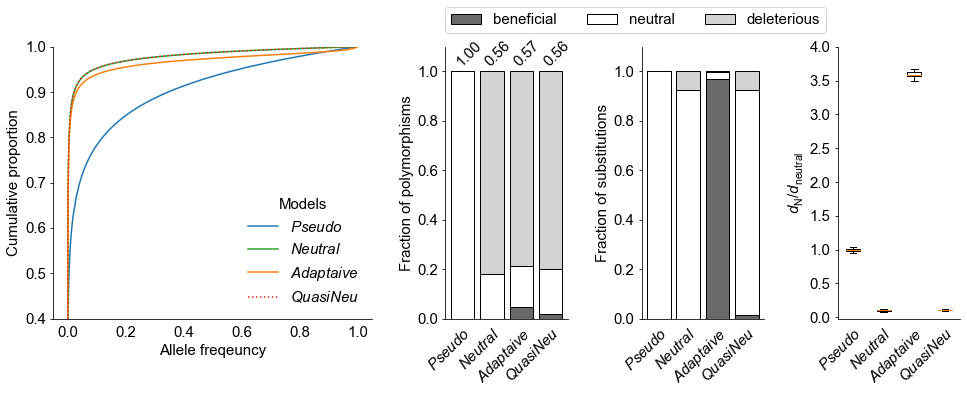

In [13]:
line_type_dict = {
    'Pseudo':'-',
    'Neutral':'-',
    'Adaptive':'-',
    'quasi_pop10000':':'
}
color_list = ['C0','C2','C1','C3']

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6,)
ax2 = fig.add_subplot(gs[0, 0:2],)
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\it{Pseudo}$','$\it{Neutral}$','$\it{Adaptaive}$','$\it{QuasiNeu}$']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for k,version in enumerate(['Pseudo','Neutral','Adaptive','quasi_pop10000']):
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),
             ls=line_type_dict[version],label=type_list[k],color=color_list[k])
ax2.legend(title='Models',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.4,1)

for idx,i in enumerate([0,1,2,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[0,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.2,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45
    )


ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)

ax4.set_xticks([0,1,2,3])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[0,1,2,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax5.set_xticks([1,2,3,4])
ax5.set_ylim(-0.02,4)
ax5.set_xlim(0.5,4.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
plt.savefig(f'./Figures/Fig2_1.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/3410449810.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


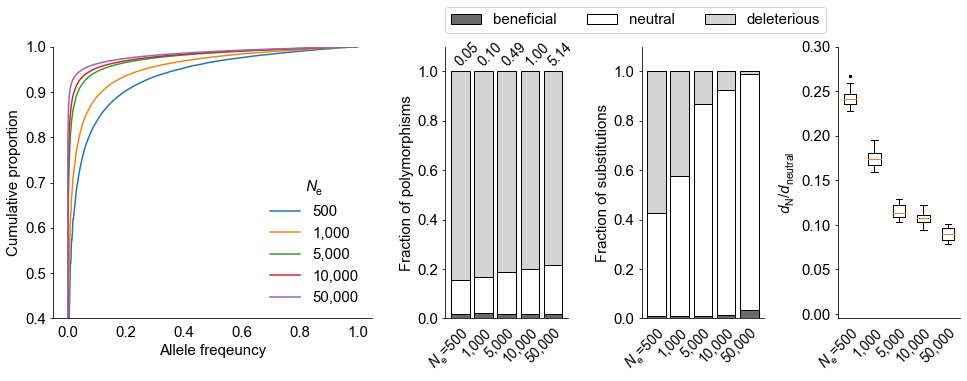

In [22]:
label_dict = {
    'quasi_pop500':'500',
    'quasi_pop1000':'1,000',
    'quasi_pop5000':'5,000',
    'quasi_pop10000':'10,000',
    'quasi_pop50000':'50,000'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{N}_e$=500','1,000','5,000','10,000','50,000']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_pop500','quasi_pop1000','quasi_pop5000','quasi_pop10000','quasi_pop50000']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),
             label=label_dict[version])
ax2.legend(title='$\mathit{N}_e$',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.4,1)

for idx,i in enumerate([15,16,17,18,19]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=14
    )

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,size=14,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)

ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels(
    type_list, rotation = 45,size=14,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[15,16,17,18,19],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops=flierprops
    )
ax5.set_xticks([1,2,3,4,5])
ax5.set_ylim(-0.005,0.3)
ax5.set_xlim(0.5,5.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
plt.savefig(f'./Figures/Fig2_2.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/3222673765.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


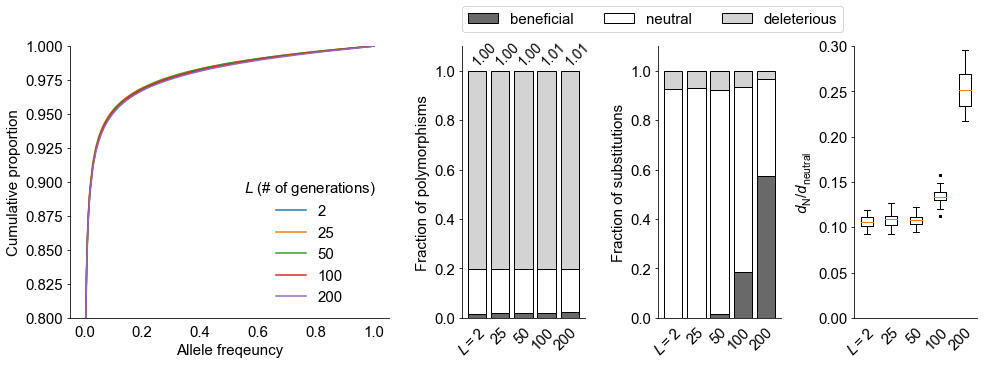

In [23]:
label_dict = {
    'quasi_int2':'2',
    'quasi_int25':'25',
    'quasi_pop10000':'50',
    'quasi_int100':'100',
    'quasi_int200':'200'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2],)
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{L}=2$','25','50','100','200']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_int2','quasi_int25','quasi_pop10000','quasi_int100','quasi_int200']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='$\mathit{L}$ (# of generations)',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([11,12,18,13,14]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=14
    )

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)

ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[11,12,18,13,14],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax5.set_xticks([1,2,3,4,5])
ax5.set_ylim(0,0.3)
ax5.set_xlim(0.5,5.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
plt.savefig(f'./Figures/Fig2_3.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/870308510.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


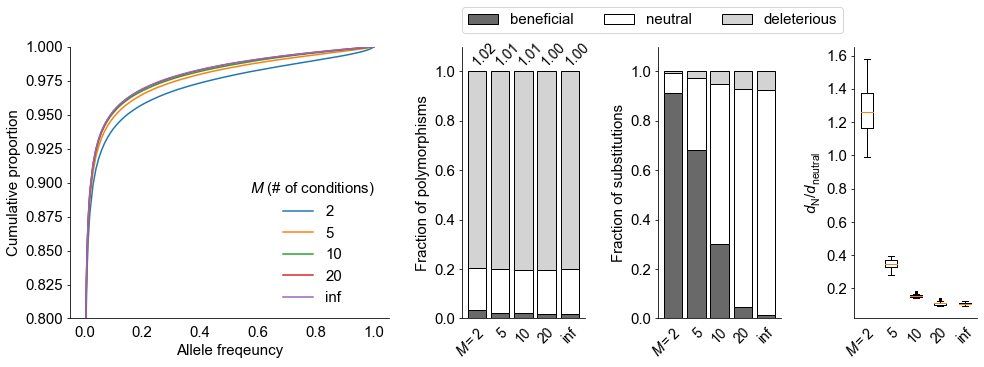

In [24]:
label_dict = {
    'quasi_env2':'2',
    'quasi_env5':'5',
    'quasi_env10':'10',
    'quasi_env20':'20',
    'quasi_pop10000':'inf'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{M}=2$','5','10','20','inf']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_env2','quasi_env5','quasi_env10','quasi_env20','quasi_pop10000']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='$\mathit{M}$ (# of conditions)',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([7,8,9,10,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=14
    )

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)

ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[7,8,9,10,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax5.set_xticks([1,2,3,4,5])
#ax5.set_ylim(0.05,0.15)
ax5.set_xlim(0.5,5.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=14)
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
plt.savefig(f'./Figures/Fig2_4.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/3885508881.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


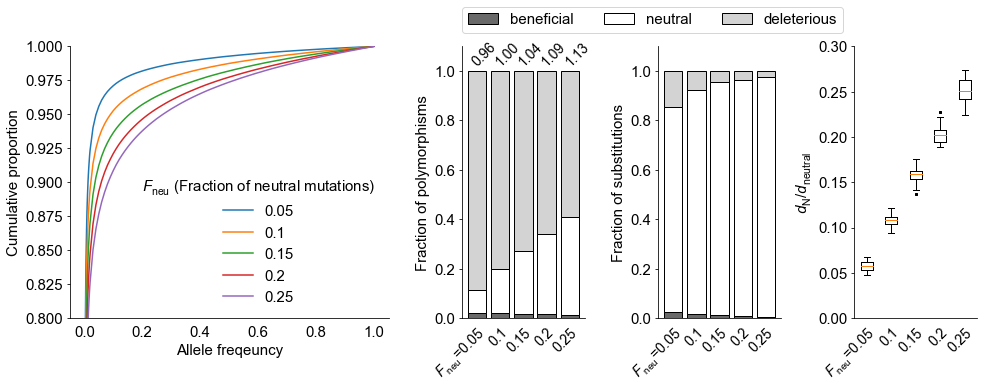

In [25]:
label_dict = {
    'quasi_neufrac0.05':'0.05',
    'quasi_pop10000':'0.1',
    'quasi_neufrac0.15':'0.15',
    'quasi_neufrac0.2':'0.2',
    'quasi_neufrac0.25':'0.25',
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{F}_{neu}$=0.05','0.1','0.15','0.2','0.25']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_neufrac0.05','quasi_pop10000','quasi_neufrac0.15','quasi_neufrac0.2','quasi_neufrac0.25']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='$\mathit{F}_{neu}$ (Fraction of neutral mutations)',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([20,18,21,22,23]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,fontsize=14
    )

ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',fontsize=14)
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)

ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',fontsize=14)
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[20,18,21,22,23],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax5.set_xticks([1,2,3,4,5])
ax5.set_ylim(0,0.3)
ax5.set_xlim(0.5,5.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',fontsize=14)
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
plt.savefig(f'./Figures/FigS3_1.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/3831541301.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


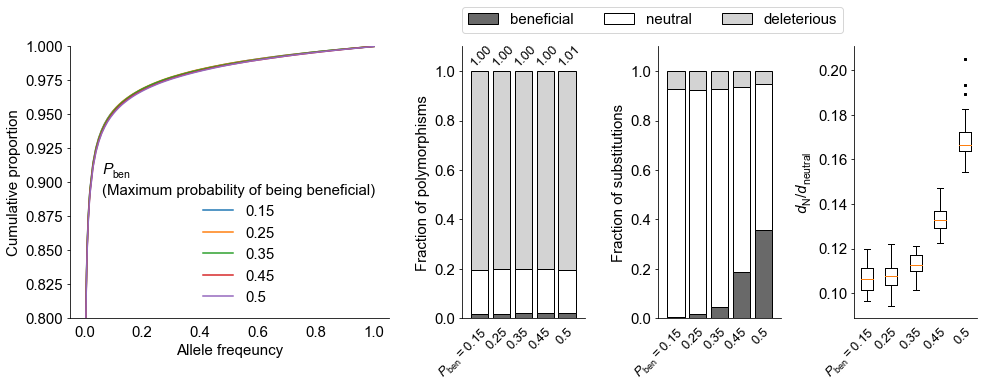

In [43]:
meanORinst = 'inst'
label_dict = {
    'quasi_AP0.15':'0.15',
    'quasi_pop10000':'0.25',
    'quasi_AP0.35':'0.35',
    'quasi_AP0.45':'0.45',
    'quasi_AP0.5':'0.5',
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{P}_{ben}=0.15$','0.25','0.35','0.45','0.5']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_AP0.15','quasi_pop10000','quasi_AP0.35','quasi_AP0.45','quasi_AP0.5']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='$\mathit{P}_{ben}$ \n(Maximum probability of being beneficial)',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([29,18,30,31,32]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.1,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=13
    )
    
ax3.set_xticks([0,1,2,3,4])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)
ax3.set_xlim(-0.8,4.8)

ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)
ax4.set_xlim(-0.8,4.8)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[29,18,30,31,32],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        widths=0.5,flierprops=flierprops
    )
ax5.set_xticks([1,2,3,4,5])
#ax5.set_ylim(0,0.15)
ax5.set_xlim(0.5,5.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$',fontsize=15)

plt.tight_layout()
plt.savefig(f'Figures/FigS3_2.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/882571126.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


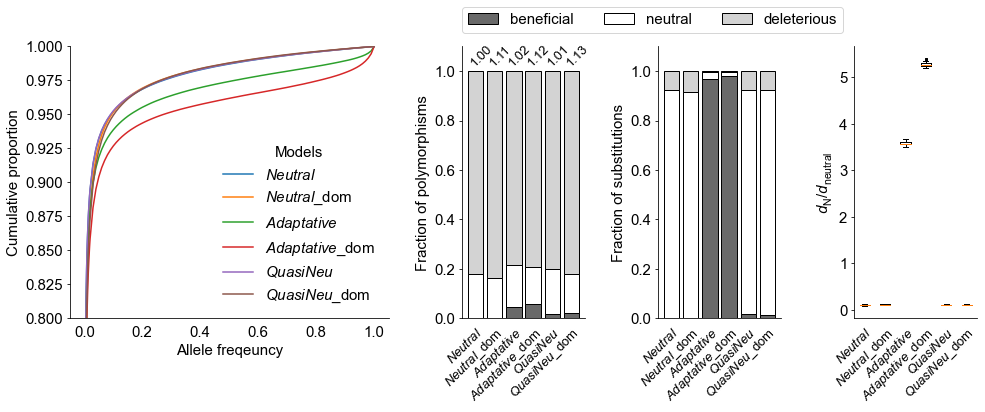

In [44]:
label_dict = {
    'Neutral':'$\mathit{Neutral}$',
    'Neutral_dom':'$\mathit{Neutral}$_dom',
    'Adaptive':'$\mathit{Adaptative}$',
    'Adaptive_dom':'$\mathit{Adaptative}$_dom',
    'quasi_pop10000':'$\mathit{QuasiNeu}$',
    'quasi_dom':'$\mathit{QuasiNeu}$_dom'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['$\mathit{Neutral}$','$\mathit{Neutral}$_dom','$\mathit{Adaptative}$',
             '$\mathit{Adaptative}$_dom','$\mathit{QuasiNeu}$','$\mathit{QuasiNeu}$_dom']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['Neutral','Neutral_dom','Adaptive','Adaptive_dom','quasi_pop10000','quasi_dom']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='Models', framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([1,3,2,4,18,6]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[1,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.3,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=13
    )

ax3.set_xticks([0,1,2,3,4,5])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)

ax4.set_xticks([0,1,2,3,4,5])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[1,3,2,4,18,6],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,
        flierprops = flierprops
    )
ax5.set_xticks([1,2,3,4,5,6])
#ax5.set_ylim(0.05,0.15)
ax5.set_xlim(0.5,6.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$')

plt.tight_layout()
plt.savefig(f'Figures/FigS3_3.pdf',bbox_inches='tight')

/tmp/ipykernel_60267/1267613461.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


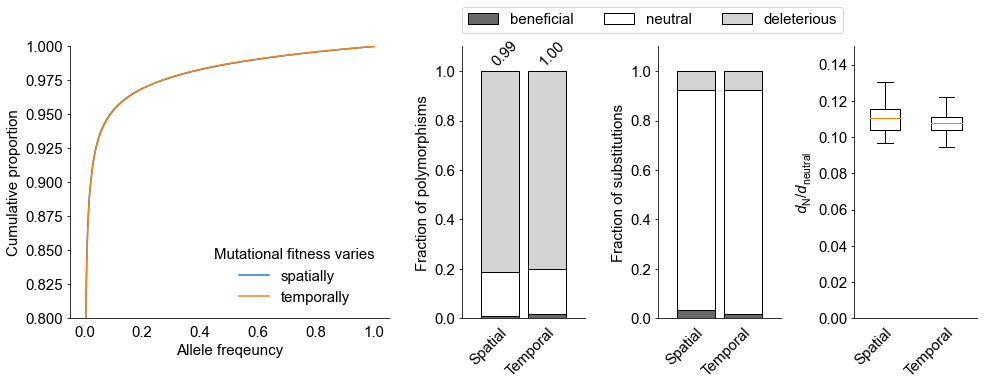

In [45]:
label_dict = {
    'quasi_stablespace20':'spatially',
    'quasi_pop10000':'temporally'
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['Spatial','Temporal']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_stablespace20','quasi_pop10000']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='Mutational fitness varies',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([5,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.1,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45
    )
    
ax3.set_xticks([0,1])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)
ax3.set_xlim(-0.8,1.8)

ax4.set_xticks([0,1])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)
ax4.set_xlim(-0.8,1.8)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[5,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,widths=0.5,
        flierprops = flierprops
    )
ax5.set_xticks([1,2])
ax5.set_ylim(0,0.15)
ax5.set_xlim(0.5,2.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor')
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$',fontsize=15)

plt.tight_layout()
plt.savefig(f'Figures/FigS3_4.pdf',bbox_inches='tight')

/tmp/ipykernel_85728/2387090769.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


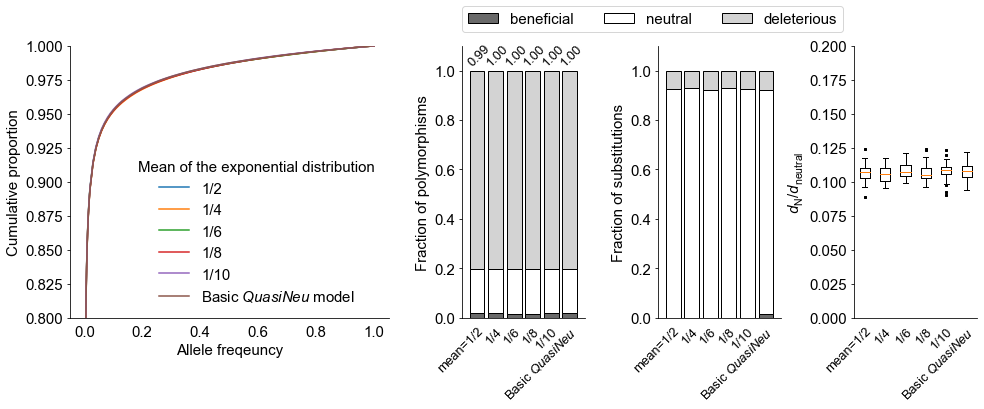

In [23]:
label_dict = {
    'quasi_lambda2':'1/2',
    'quasi_lambda4':'1/4',
    'quasi_lambda6':'1/6',
    'quasi_lambda8':'1/8',
    'quasi_lambda10':'1/10',
    'quasi_pop10000':'Basic $\mathit{QuasiNeu}$ model',
}

fig = plt.figure(constrained_layout=False, facecolor='w',figsize=[18,5])
gs = fig.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.6)
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4= fig.add_subplot(gs[0, 3])
ax5= fig.add_subplot(gs[0, 4])
mut_type_list = ['beneficial','neutral','deleterious']
type_list = ['mean=1/2','1/4','1/6','1/8','1/10','Basic $\mathit{QuasiNeu}$']

x_list = np.concatenate((np.linspace(0,0.02,21), np.linspace(0.03,1,98)))
for version in ['quasi_lambda2','quasi_lambda4','quasi_lambda6',
                'quasi_lambda8','quasi_lambda10','quasi_pop10000']:
    ax2.plot(x_list,[0]+spectrum_final_dict[version][0:].tolist(),alpha=1,
             label=label_dict[version])
ax2.legend(title='Mean of the exponential distribution',framealpha=0)
ax2.set_xlabel('Allele freqeuncy',fontsize=15)
ax2.set_ylabel('Cumulative proportion',fontsize=15)
ax2.set_ylim(0.8,1)

for idx,i in enumerate([24,25,26,27,28,18]):
    for j,mut_type in enumerate(mut_type_list):
        meanORinst = 'inst'
        ax3.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_P'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_P' for jj in range(j)]].sum(),
            color=color_list2[j], label= mut_type_list[j] if idx == 0 else None
        )
        meanORinst = 'effective'
        ax4.bar(
            idx, plt_df.loc[i,f'{mut_type}_{meanORinst}_S'],
            bottom=plt_df.loc[i,[f'{mut_type_list[jj]}_{meanORinst}_S' for jj in range(j)]].sum(),
            color=color_list2[j]
        )
        
    meanORinst = 'inst'
    ratio_P = summary_df.loc[i,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()/ \
            summary_df.loc[18,[f'{mut_type}_{meanORinst}_P' for mut_type in mut_type_list]].sum()
    ax3.text(
        x=idx+0.1,y=1.02,ha='center',
        s=f'{ratio_P:.2f}',rotation=45,size=13
    )
    
ax3.set_xticks([0,1,2,3,4,5])
ax3.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax3.set_ylabel('Fraction of polymorphisms')
ax3.legend(loc=[0,1.05], ncol=3)
ax3.set_ylim(0,1.1)
ax3.set_xlim(-0.8,5.8)

ax4.set_xticks([0,1,2,3,4,5])
ax4.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax4.set_ylabel('Fraction of substitutions')
ax4.set_ylim(0,1.1)
ax4.set_xlim(-0.8,5.8)

for rep in range(1,31):
    ax5.boxplot(
        plt_df.loc[[24,25,26,27,28,18],[f'dNdneutral_{rep}' for rep in range(1,31)]].to_numpy().T,widths=0.5,
        flierprops = flierprops
    )
ax5.set_xticks([1,2,3,4,5,6])
ax5.set_ylim(0,0.2)
ax5.set_xlim(0.5,6.5)
ax5.set_xticklabels(
    type_list, rotation = 45,
    ha='right', rotation_mode='anchor',size=13)
ax5.set_ylabel('$\mathit{d}_{N}/\mathit{d}_{neutral}$',fontsize=15)

plt.tight_layout()
plt.savefig(f'Figures/FigS3_5.pdf',bbox_inches='tight')

In [17]:
A = np.array([
    [0.5,0.5],
    [0.5/7,1-0.5/7]
])
np.linalg.matrix_power(A,50)

array([[0.12702624, 0.87297376],
       [0.12471054, 0.87528946]])

In [19]:
A = np.array([
    [0.5,0.5],
    [0.5/7,1-0.5/7]
])
np.linalg.matrix_power(A,50)

array([[0.125, 0.875],
       [0.125, 0.875]])

In [18]:
5/6

0.8333333333333334